In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
grid = (5,5) # grid size
num_data = 1000 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+100+1000, num_feat, grid, deg, e, seed=42)

In [3]:
from pyepo.model.grb import shortestPathModel
# set solver
optmodel = shortestPathModel(grid)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(optmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 3.6258033206091707
(0, 1)
(1, 6)
(6, 7)
(7, 12)
(12, 17)
(17, 18)
(18, 19)
(19, 24)


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1026.22it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1067.54it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 829.61it/s]


In [6]:
# get training and test data set without costs
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, sols=dataset_train_cost.sols)

Obtaining constraints for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 580.33it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt

def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-0.5, num_epochs+0.5)
    plt.ylim(0, 0.8)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 20
log_step = 1

In [11]:
import copy
import time
from tqdm import tqdm
from clipgrad import clipGrad

def pipeline(reg, optimizer, forward_func, loss_func, num_epochs, log_step,
             loader_train, loader_val, loader_test, seed=42, grad_clip=False):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # clip gradients
            if grad_clip:
                clipGrad(reg, threshold=1e-6)
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
    regret_log_trn.append(regret_trn)
    regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
    regret_log_val.append(regret_val)
    tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
               format(epoch, regret_trn*100, regret_val*100))
    # load best model
    reg.load_state_dict(best_model_state)
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

### Large Learning Rate 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

def forwardCAVE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

(CVXPY) Dec 02 06:11:32 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
Num of cores: 8


In [14]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [15]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, optimizer, forwardCAVE, ca_cos, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:01<?, ?it/s]

Epoch   0, Train Regret:  61.9579%, Val Regret:  66.5088%


Epoch    0, Loss:  -0.9965:   5%|██▊                                                    | 1/20 [00:15<04:05, 12.92s/it]

Epoch   1, Train Regret:  24.3093%, Val Regret:  25.6911%


Epoch    1, Loss:  -0.9986:  10%|█████▌                                                 | 2/20 [00:20<02:36,  8.71s/it]

Epoch   2, Train Regret:  12.7090%, Val Regret:   9.9501%


Epoch    2, Loss:  -0.9997:  15%|████████▎                                              | 3/20 [00:25<02:00,  7.09s/it]

Epoch   3, Train Regret:  10.5814%, Val Regret:   8.5022%


Epoch    3, Loss:  -0.9997:  20%|███████████                                            | 4/20 [00:30<01:42,  6.38s/it]

Epoch   4, Train Regret:  10.0008%, Val Regret:   9.4080%


Epoch    4, Loss:  -0.9999:  25%|█████████████▊                                         | 5/20 [00:36<01:29,  5.98s/it]

Epoch   5, Train Regret:  10.6211%, Val Regret:   9.4636%


Epoch    5, Loss:  -1.0000:  30%|████████████████▌                                      | 6/20 [00:41<01:20,  5.73s/it]

Epoch   6, Train Regret:  10.4478%, Val Regret:   8.0448%


Epoch    6, Loss:  -1.0000:  35%|███████████████████▎                                   | 7/20 [00:46<01:13,  5.68s/it]

Epoch   7, Train Regret:  10.3868%, Val Regret:   9.5071%


Epoch    7, Loss:  -0.9999:  40%|██████████████████████                                 | 8/20 [00:51<01:05,  5.47s/it]

Epoch   8, Train Regret:   9.8455%, Val Regret:   8.7804%


Epoch    8, Loss:  -1.0000:  45%|████████████████████████▊                              | 9/20 [00:57<00:58,  5.35s/it]

Epoch   9, Train Regret:  10.0641%, Val Regret:   9.1773%


Epoch    9, Loss:  -1.0000:  50%|███████████████████████████                           | 10/20 [01:02<00:52,  5.25s/it]

Epoch  10, Train Regret:   9.8760%, Val Regret:   9.3563%


Epoch   10, Loss:  -1.0000:  55%|█████████████████████████████▋                        | 11/20 [01:07<00:47,  5.25s/it]

Epoch  11, Train Regret:   9.9056%, Val Regret:  10.2690%


Epoch   11, Loss:  -1.0000:  60%|████████████████████████████████▍                     | 12/20 [01:12<00:41,  5.19s/it]

Epoch  12, Train Regret:   9.1781%, Val Regret:   9.0100%


Epoch   12, Loss:  -1.0000:  65%|███████████████████████████████████                   | 13/20 [01:18<00:37,  5.30s/it]

Epoch  13, Train Regret:  10.5946%, Val Regret:  11.6057%


Epoch   13, Loss:  -1.0000:  70%|█████████████████████████████████████▊                | 14/20 [01:23<00:32,  5.34s/it]

Epoch  14, Train Regret:  11.1633%, Val Regret:  12.0179%


Epoch   14, Loss:  -1.0000:  75%|████████████████████████████████████████▌             | 15/20 [01:28<00:26,  5.34s/it]

Epoch  15, Train Regret:   9.4052%, Val Regret:   9.5397%


Epoch   15, Loss:  -1.0000:  80%|███████████████████████████████████████████▏          | 16/20 [01:34<00:21,  5.41s/it]

Epoch  16, Train Regret:  10.6698%, Val Regret:  10.2814%


Epoch   16, Loss:  -1.0000:  85%|█████████████████████████████████████████████▉        | 17/20 [01:39<00:16,  5.35s/it]

Epoch  17, Train Regret:   8.7009%, Val Regret:  10.4877%


Epoch   17, Loss:  -1.0000:  90%|████████████████████████████████████████████████▌     | 18/20 [01:44<00:10,  5.29s/it]

Epoch  18, Train Regret:  12.0717%, Val Regret:  12.6308%


Epoch   18, Loss:  -1.0000:  95%|███████████████████████████████████████████████████▎  | 19/20 [01:49<00:05,  5.31s/it]

Epoch  19, Train Regret:  11.2230%, Val Regret:  12.0071%


Epoch   19, Loss:  -1.0000: 100%|██████████████████████████████████████████████████████| 20/20 [01:53<00:00,  5.67s/it]


Epoch  19, Train Regret:  10.3637%, Val Regret:   9.6777%

Evaluation:
Test Regret: 9.8216%
Training Elapsed Time: 57.20 Sec


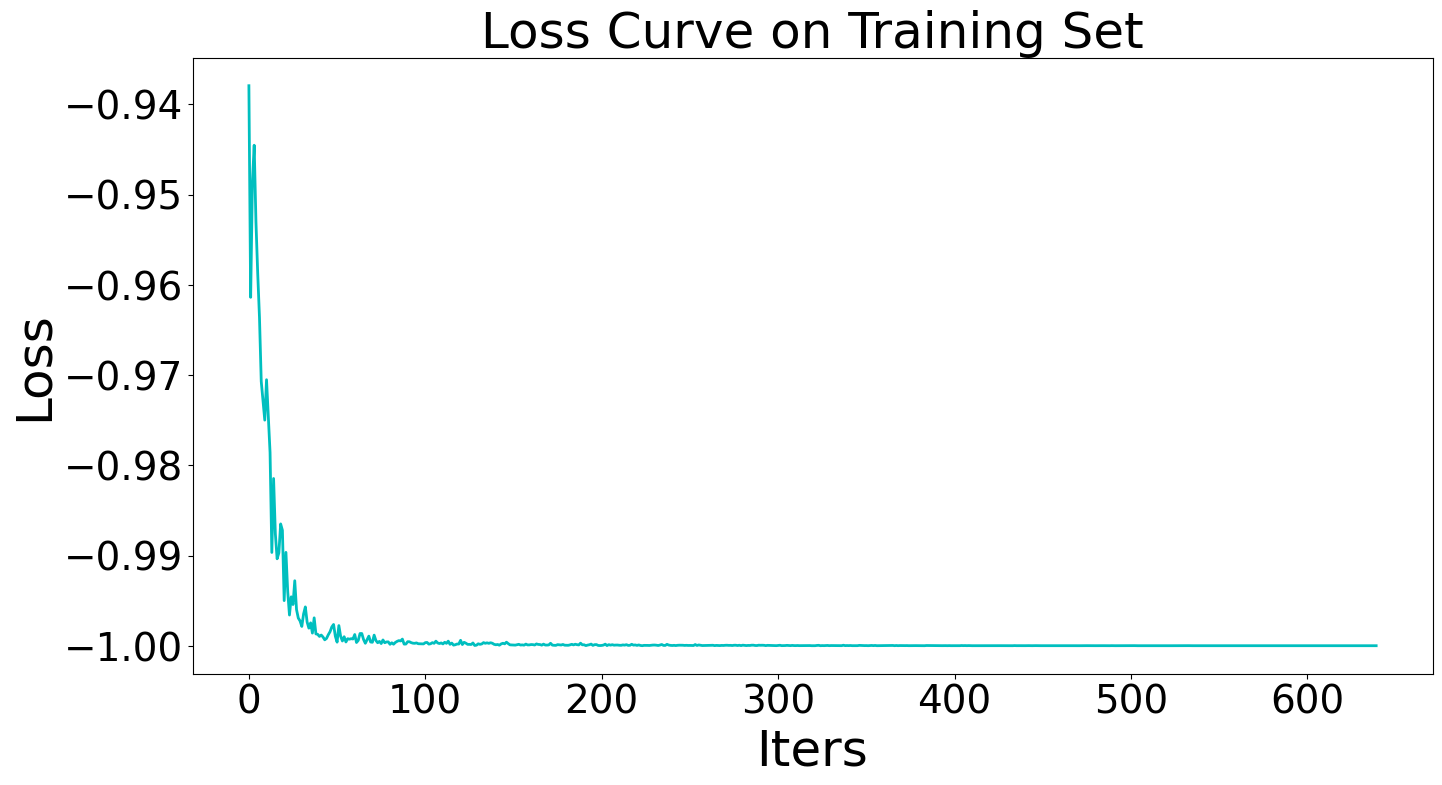

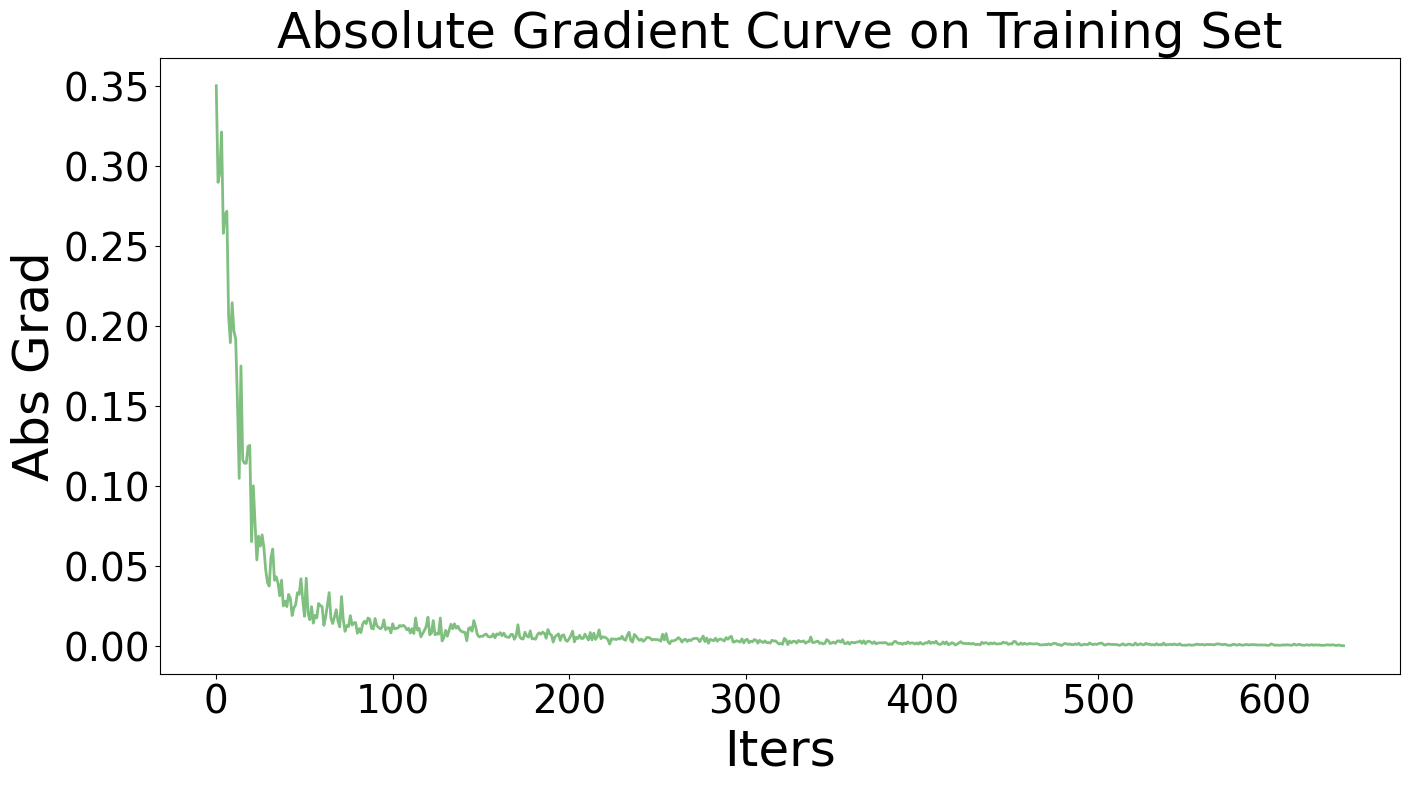

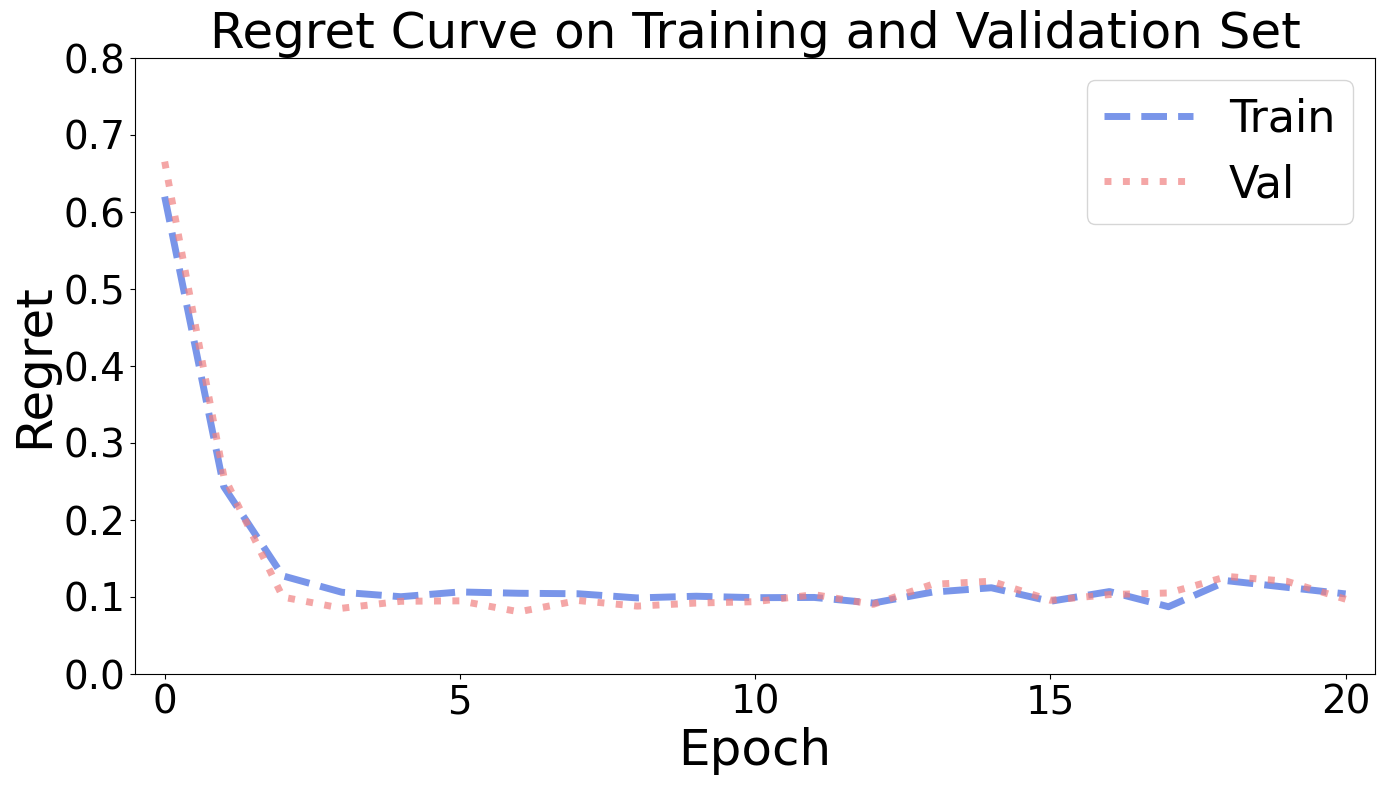

In [16]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

In [17]:
# change learning rate
for param_group in optimizer.param_groups:
            param_group["lr"] = 1e0

In [18]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, optimizer, forwardCAVE, ca_cos, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:01<?, ?it/s]

Epoch   0, Train Regret:  10.4478%, Val Regret:   8.0448%


Epoch    0, Loss:  -0.9966:   5%|██▊                                                    | 1/20 [00:06<01:35,  5.02s/it]

Epoch   1, Train Regret:  10.4217%, Val Regret:   9.6043%


Epoch    1, Loss:  -0.9992:  10%|█████▌                                                 | 2/20 [00:11<01:31,  5.06s/it]

Epoch   2, Train Regret:   9.2954%, Val Regret:   7.5542%


Epoch    2, Loss:  -0.9999:  15%|████████▎                                              | 3/20 [00:16<01:25,  5.04s/it]

Epoch   3, Train Regret:   8.2707%, Val Regret:   8.2188%


Epoch    3, Loss:  -0.9999:  20%|███████████                                            | 4/20 [00:21<01:20,  5.05s/it]

Epoch   4, Train Regret:   8.4842%, Val Regret:   8.4274%


Epoch    4, Loss:  -0.9997:  25%|█████████████▊                                         | 5/20 [00:27<01:16,  5.08s/it]

Epoch   5, Train Regret:   8.9671%, Val Regret:   8.9740%


Epoch    5, Loss:  -0.9999:  30%|████████████████▌                                      | 6/20 [00:32<01:11,  5.12s/it]

Epoch   6, Train Regret:   8.6987%, Val Regret:   9.7193%


Epoch    6, Loss:  -1.0000:  35%|███████████████████▎                                   | 7/20 [00:37<01:06,  5.15s/it]

Epoch   7, Train Regret:   9.0685%, Val Regret:  11.3596%


Epoch    7, Loss:  -0.9998:  40%|██████████████████████                                 | 8/20 [00:42<01:01,  5.10s/it]

Epoch   8, Train Regret:   9.6534%, Val Regret:  10.1707%


Epoch    8, Loss:  -0.9999:  45%|████████████████████████▊                              | 9/20 [00:47<00:55,  5.07s/it]

Epoch   9, Train Regret:   9.7125%, Val Regret:  10.1507%


Epoch    9, Loss:  -1.0000:  50%|███████████████████████████                           | 10/20 [00:52<00:50,  5.04s/it]

Epoch  10, Train Regret:   9.4506%, Val Regret:  10.7317%


Epoch   10, Loss:  -1.0000:  55%|█████████████████████████████▋                        | 11/20 [00:57<00:45,  5.06s/it]

Epoch  11, Train Regret:   9.7122%, Val Regret:  12.0791%


Epoch   11, Loss:  -1.0000:  60%|████████████████████████████████▍                     | 12/20 [01:02<00:40,  5.06s/it]

Epoch  12, Train Regret:   8.9904%, Val Regret:  10.2618%


Epoch   12, Loss:  -1.0000:  65%|███████████████████████████████████                   | 13/20 [01:07<00:35,  5.04s/it]

Epoch  13, Train Regret:  10.7201%, Val Regret:  12.4598%


Epoch   13, Loss:  -1.0000:  70%|█████████████████████████████████████▊                | 14/20 [01:12<00:30,  5.06s/it]

Epoch  14, Train Regret:  10.4706%, Val Regret:  10.2393%


Epoch   14, Loss:  -1.0000:  75%|████████████████████████████████████████▌             | 15/20 [01:17<00:25,  5.08s/it]

Epoch  15, Train Regret:   8.9987%, Val Regret:  12.4772%


Epoch   15, Loss:  -1.0000:  80%|███████████████████████████████████████████▏          | 16/20 [01:23<00:20,  5.12s/it]

Epoch  16, Train Regret:   9.7446%, Val Regret:  10.5754%


Epoch   16, Loss:  -1.0000:  85%|█████████████████████████████████████████████▉        | 17/20 [01:28<00:15,  5.14s/it]

Epoch  17, Train Regret:   9.1731%, Val Regret:  11.2533%


Epoch   17, Loss:  -1.0000:  90%|████████████████████████████████████████████████▌     | 18/20 [01:33<00:10,  5.25s/it]

Epoch  18, Train Regret:  10.7700%, Val Regret:  12.4722%


Epoch   18, Loss:  -1.0000:  95%|███████████████████████████████████████████████████▎  | 19/20 [01:38<00:05,  5.23s/it]

Epoch  19, Train Regret:  10.9162%, Val Regret:  12.8981%


Epoch   19, Loss:  -1.0000: 100%|██████████████████████████████████████████████████████| 20/20 [01:42<00:00,  5.12s/it]


Epoch  19, Train Regret:  10.3355%, Val Regret:  10.7179%

Evaluation:
Test Regret: 9.3702%
Training Elapsed Time: 47.93 Sec


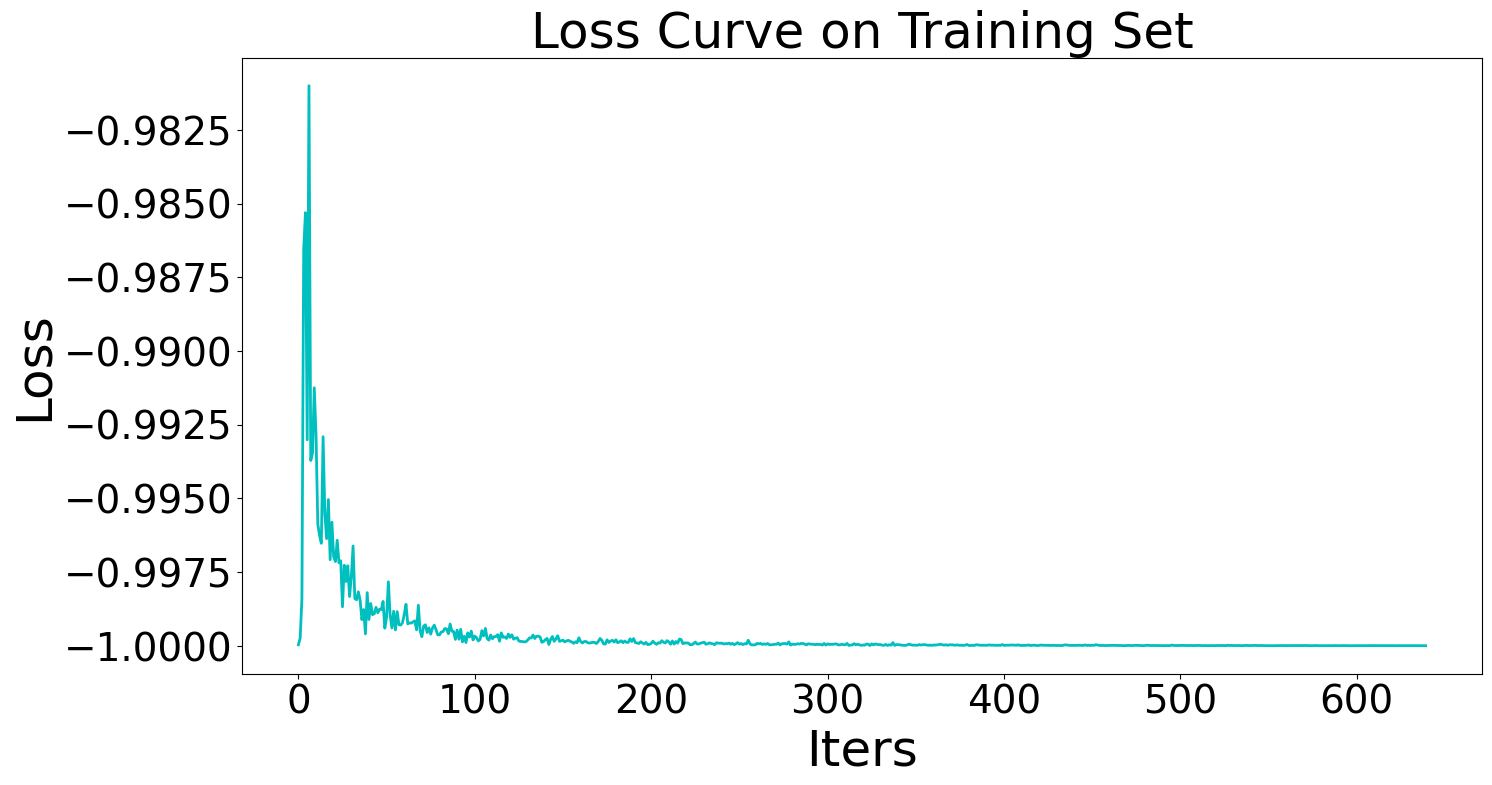

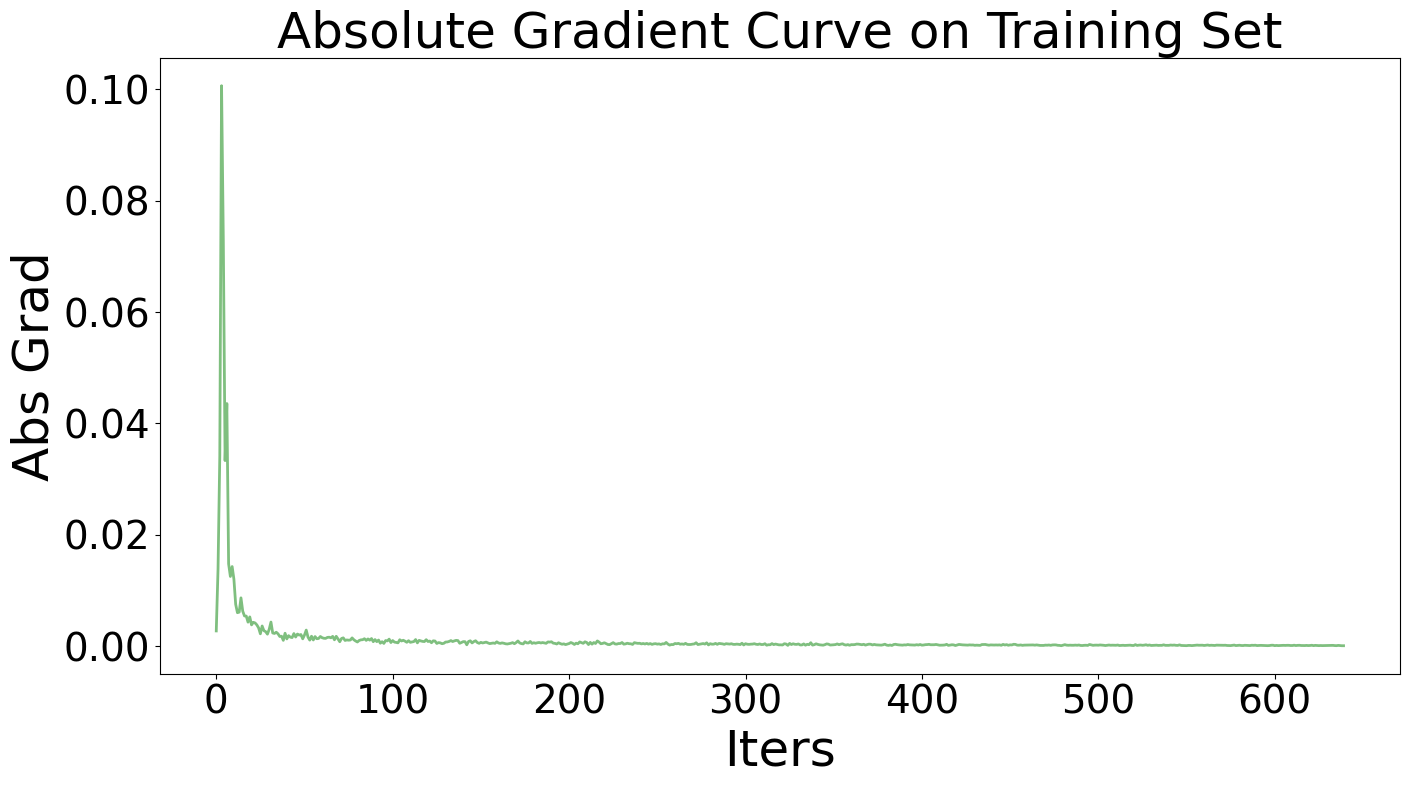

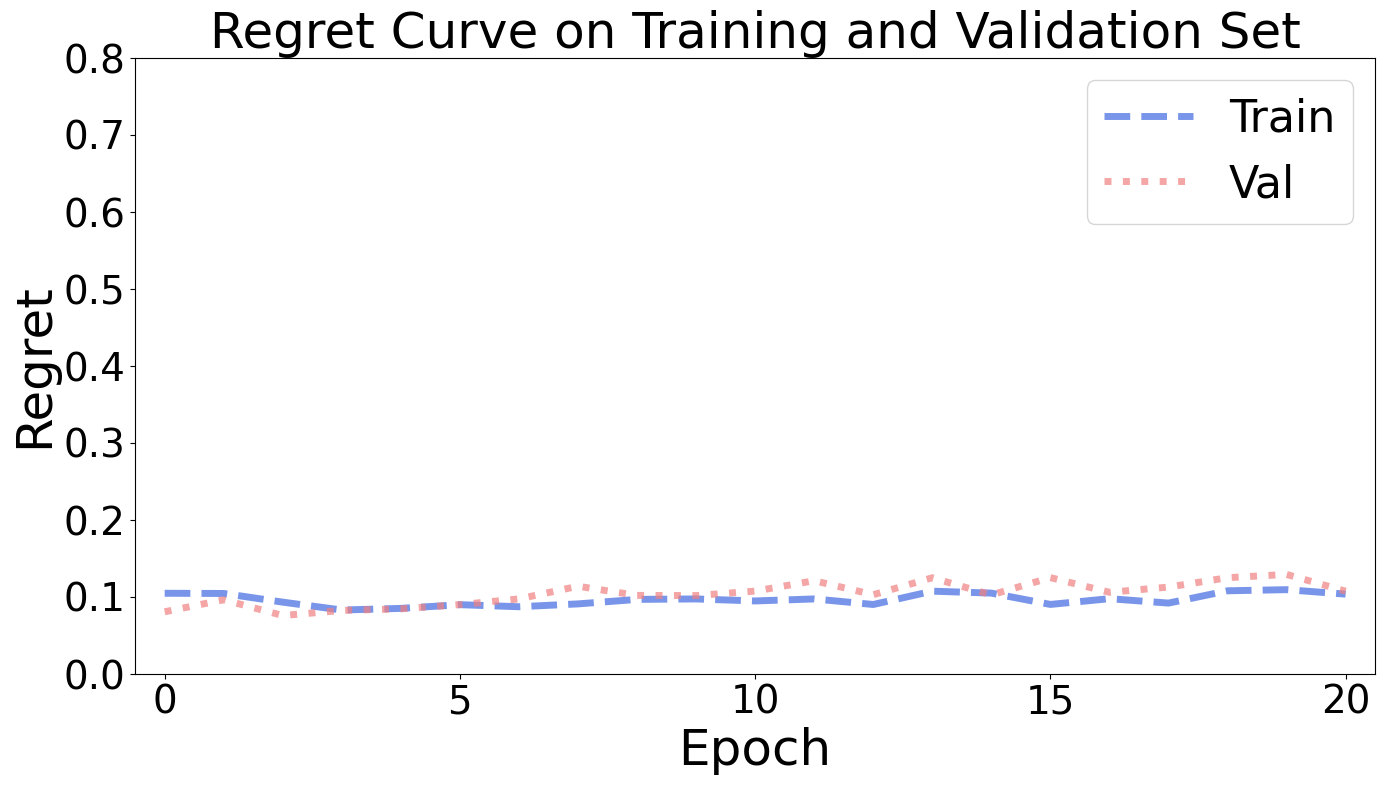

In [19]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Gradient Clip 

In [20]:
# init model
reg = LinearRegression()

In [21]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [22]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, optimizer, forwardCAVE, ca_cos, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test, grad_clip=True)

  0%|                                                                                           | 0/20 [00:01<?, ?it/s]

Epoch   0, Train Regret:  57.4740%, Val Regret:  57.0021%


Epoch    0, Loss:  -0.9973:   5%|██▊                                                    | 1/20 [00:06<01:38,  5.17s/it]

Epoch   1, Train Regret:  15.4758%, Val Regret:  19.6687%


Epoch    1, Loss:  -0.9990:  10%|█████▌                                                 | 2/20 [00:11<01:31,  5.09s/it]

Epoch   2, Train Regret:  11.0800%, Val Regret:  10.7767%


Epoch    2, Loss:  -0.9999:  15%|████████▎                                              | 3/20 [00:17<01:26,  5.09s/it]

Epoch   3, Train Regret:  10.1780%, Val Regret:  10.9322%


Epoch    3, Loss:  -0.9999:  20%|███████████                                            | 4/20 [00:22<01:21,  5.10s/it]

Epoch   4, Train Regret:  10.1872%, Val Regret:  10.8735%


Epoch    4, Loss:  -0.9997:  25%|█████████████▊                                         | 5/20 [00:27<01:16,  5.07s/it]

Epoch   5, Train Regret:  10.3494%, Val Regret:  10.4627%


Epoch    5, Loss:  -1.0000:  30%|████████████████▌                                      | 6/20 [00:32<01:10,  5.06s/it]

Epoch   6, Train Regret:   9.1961%, Val Regret:   9.7609%


Epoch    6, Loss:  -1.0000:  35%|███████████████████▎                                   | 7/20 [00:37<01:05,  5.06s/it]

Epoch   7, Train Regret:   9.0730%, Val Regret:  11.6609%


Epoch    7, Loss:  -1.0000:  40%|██████████████████████                                 | 8/20 [00:42<01:00,  5.04s/it]

Epoch   8, Train Regret:   9.1284%, Val Regret:  12.2448%


Epoch    8, Loss:  -1.0000:  45%|████████████████████████▊                              | 9/20 [00:47<00:55,  5.05s/it]

Epoch   9, Train Regret:   9.2035%, Val Regret:   9.3506%


Epoch    9, Loss:  -1.0000:  50%|███████████████████████████                           | 10/20 [00:52<00:50,  5.08s/it]

Epoch  10, Train Regret:   9.6797%, Val Regret:  13.0025%


Epoch   10, Loss:  -1.0000:  55%|█████████████████████████████▋                        | 11/20 [00:57<00:45,  5.08s/it]

Epoch  11, Train Regret:   8.9281%, Val Regret:  12.5477%


Epoch   11, Loss:  -1.0000:  60%|████████████████████████████████▍                     | 12/20 [01:02<00:40,  5.10s/it]

Epoch  12, Train Regret:   9.4480%, Val Regret:  12.4584%


Epoch   12, Loss:  -1.0000:  65%|███████████████████████████████████                   | 13/20 [01:07<00:35,  5.07s/it]

Epoch  13, Train Regret:   9.9009%, Val Regret:  12.3895%


Epoch   13, Loss:  -1.0000:  70%|█████████████████████████████████████▊                | 14/20 [01:12<00:30,  5.06s/it]

Epoch  14, Train Regret:  10.9485%, Val Regret:  11.9254%


Epoch   14, Loss:  -1.0000:  75%|████████████████████████████████████████▌             | 15/20 [01:17<00:25,  5.04s/it]

Epoch  15, Train Regret:   9.2799%, Val Regret:  13.8530%


Epoch   15, Loss:  -1.0000:  80%|███████████████████████████████████████████▏          | 16/20 [01:22<00:20,  5.06s/it]

Epoch  16, Train Regret:   9.5158%, Val Regret:  12.5391%


Epoch   16, Loss:  -1.0000:  85%|█████████████████████████████████████████████▉        | 17/20 [01:27<00:15,  5.05s/it]

Epoch  17, Train Regret:  10.7252%, Val Regret:  14.6251%


Epoch   17, Loss:  -1.0000:  90%|████████████████████████████████████████████████▌     | 18/20 [01:33<00:10,  5.08s/it]

Epoch  18, Train Regret:  12.3197%, Val Regret:  14.0461%


Epoch   18, Loss:  -1.0000:  95%|███████████████████████████████████████████████████▎  | 19/20 [01:38<00:05,  5.15s/it]

Epoch  19, Train Regret:  10.5308%, Val Regret:  13.6990%


Epoch   19, Loss:  -1.0000: 100%|██████████████████████████████████████████████████████| 20/20 [01:41<00:00,  5.09s/it]


Epoch  19, Train Regret:  11.5246%, Val Regret:  14.8103%

Evaluation:
Test Regret: 10.5592%
Training Elapsed Time: 47.61 Sec


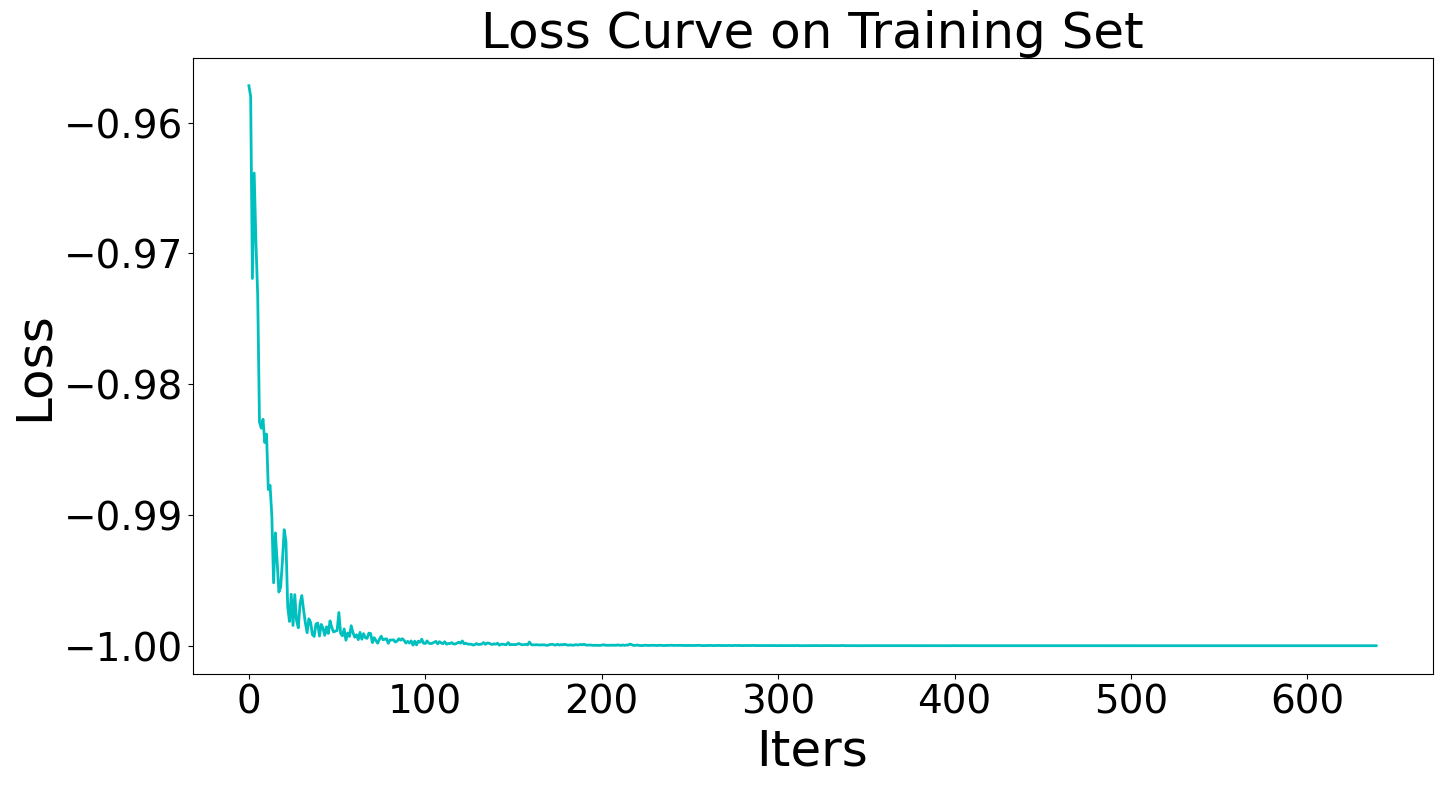

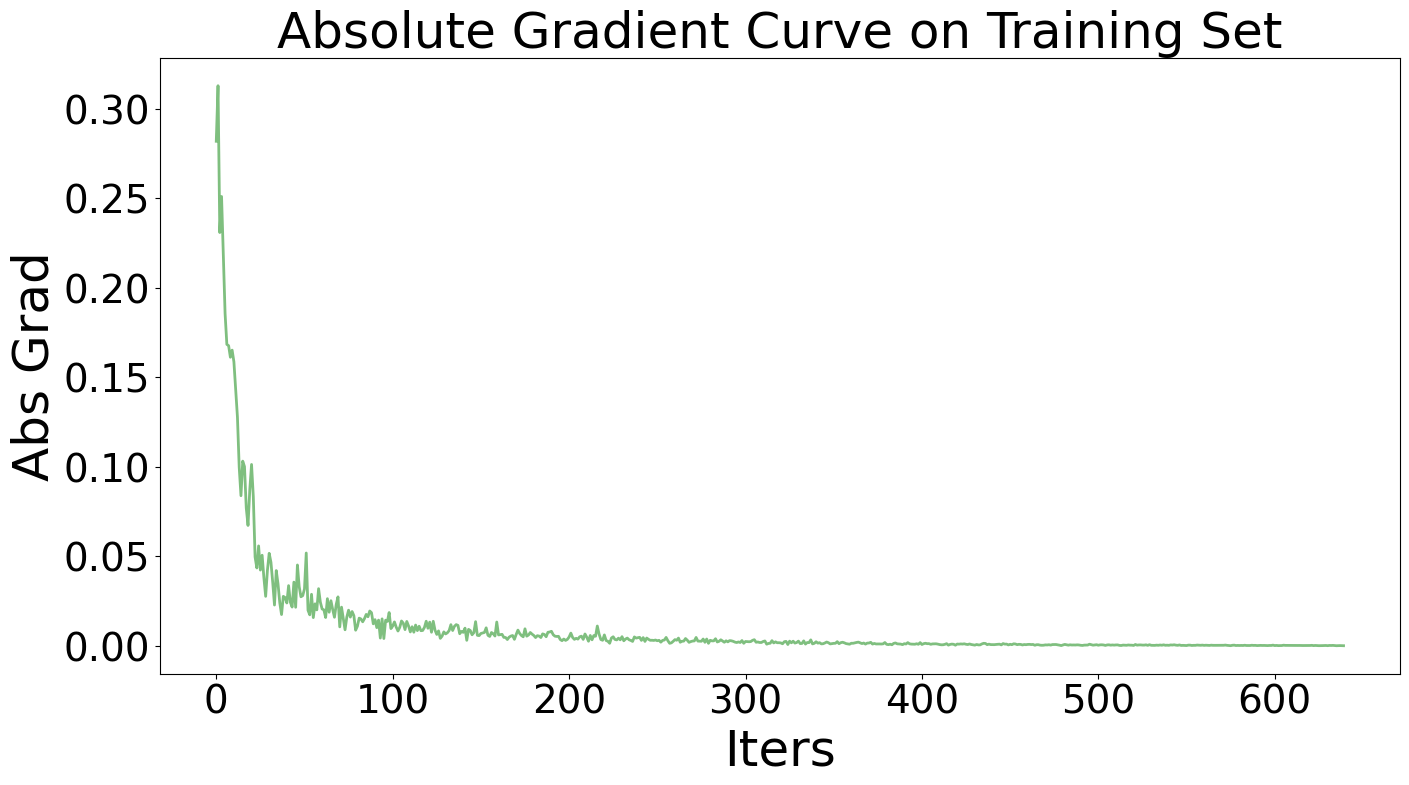

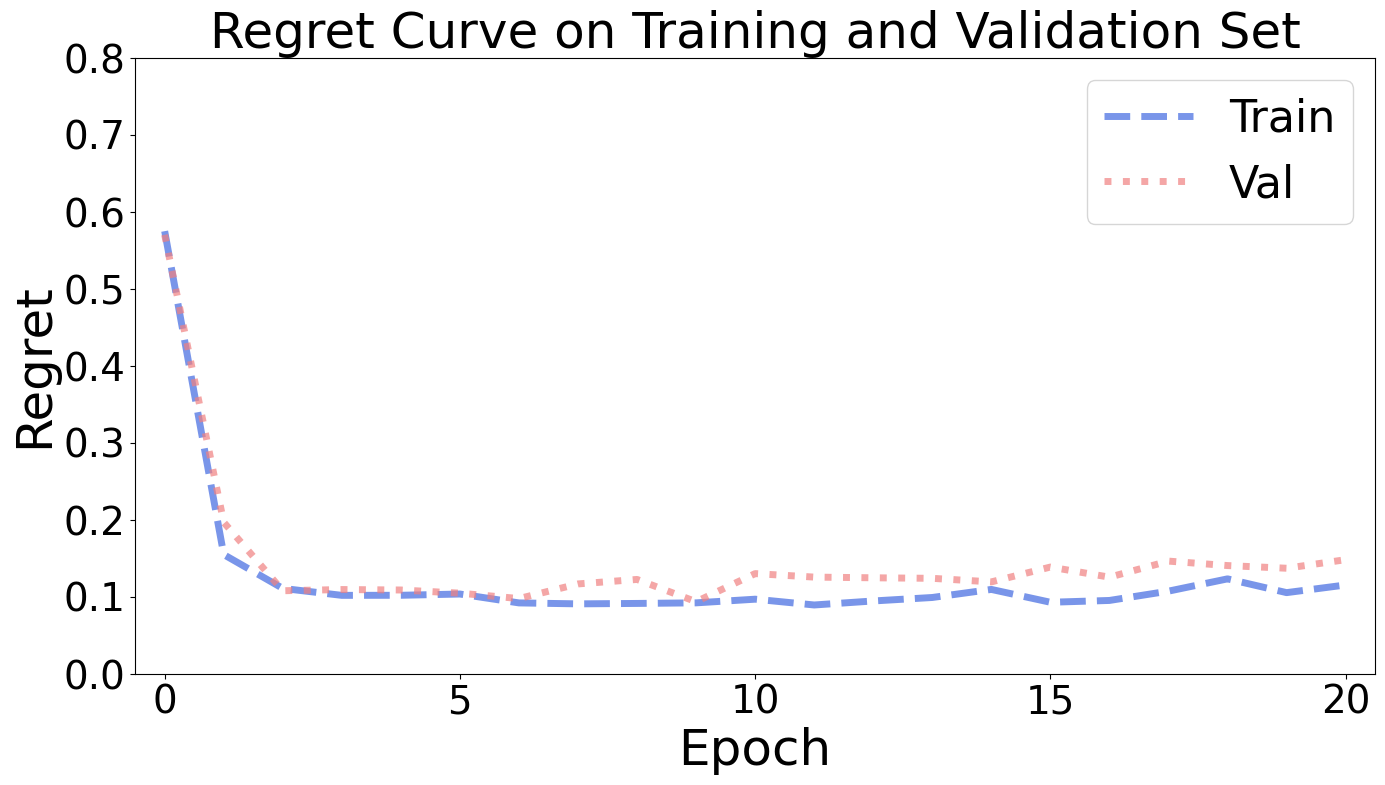

In [23]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

In [24]:
# change learning rate
for param_group in optimizer.param_groups:
            param_group["lr"] = 1e0

In [25]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, optimizer, forwardCAVE, ca_cos, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test, grad_clip=True)

  0%|                                                                                           | 0/20 [00:01<?, ?it/s]

Epoch   0, Train Regret:   9.2035%, Val Regret:   9.3506%


Epoch    0, Loss:  -0.9974:   5%|██▊                                                    | 1/20 [00:06<01:39,  5.21s/it]

Epoch   1, Train Regret:  10.4211%, Val Regret:   8.7588%


Epoch    1, Loss:  -0.9989:  10%|█████▌                                                 | 2/20 [00:11<01:32,  5.15s/it]

Epoch   2, Train Regret:   8.9692%, Val Regret:   6.7948%


Epoch    2, Loss:  -0.9999:  15%|████████▎                                              | 3/20 [00:16<01:26,  5.07s/it]

Epoch   3, Train Regret:   8.9837%, Val Regret:   8.1116%


Epoch    3, Loss:  -0.9995:  20%|███████████                                            | 4/20 [00:21<01:20,  5.03s/it]

Epoch   4, Train Regret:   9.0057%, Val Regret:   7.4852%


Epoch    4, Loss:  -0.9993:  25%|█████████████▊                                         | 5/20 [00:26<01:15,  5.02s/it]

Epoch   5, Train Regret:   9.1101%, Val Regret:   7.8803%


Epoch    5, Loss:  -0.9997:  30%|████████████████▌                                      | 6/20 [00:31<01:10,  5.01s/it]

Epoch   6, Train Regret:   8.8182%, Val Regret:   8.0671%


Epoch    6, Loss:  -0.9999:  35%|███████████████████▎                                   | 7/20 [00:37<01:05,  5.04s/it]

Epoch   7, Train Regret:   8.6869%, Val Regret:   7.3911%


Epoch    7, Loss:  -0.9997:  40%|██████████████████████                                 | 8/20 [00:42<01:00,  5.07s/it]

Epoch   8, Train Regret:   8.7187%, Val Regret:   7.6305%


Epoch    8, Loss:  -0.9998:  45%|████████████████████████▊                              | 9/20 [00:47<00:55,  5.07s/it]

Epoch   9, Train Regret:   8.8153%, Val Regret:   7.3408%


Epoch    9, Loss:  -1.0000:  50%|███████████████████████████                           | 10/20 [00:52<00:50,  5.05s/it]

Epoch  10, Train Regret:   8.9414%, Val Regret:   8.1030%


Epoch   10, Loss:  -1.0000:  55%|█████████████████████████████▋                        | 11/20 [00:57<00:45,  5.07s/it]

Epoch  11, Train Regret:   9.1487%, Val Regret:   7.6534%


Epoch   11, Loss:  -1.0000:  60%|████████████████████████████████▍                     | 12/20 [01:02<00:40,  5.08s/it]

Epoch  12, Train Regret:   9.3103%, Val Regret:  10.2423%


Epoch   12, Loss:  -1.0000:  65%|███████████████████████████████████                   | 13/20 [01:07<00:35,  5.06s/it]

Epoch  13, Train Regret:   8.8878%, Val Regret:   7.9544%


Epoch   13, Loss:  -1.0000:  70%|█████████████████████████████████████▊                | 14/20 [01:12<00:30,  5.04s/it]

Epoch  14, Train Regret:   9.2986%, Val Regret:  10.5016%


Epoch   14, Loss:  -1.0000:  75%|████████████████████████████████████████▌             | 15/20 [01:17<00:25,  5.02s/it]

Epoch  15, Train Regret:   8.5694%, Val Regret:   7.2166%


Epoch   15, Loss:  -0.9999:  80%|███████████████████████████████████████████▏          | 16/20 [01:22<00:20,  5.03s/it]

Epoch  16, Train Regret:   9.0310%, Val Regret:  10.4474%


Epoch   16, Loss:  -1.0000:  85%|█████████████████████████████████████████████▉        | 17/20 [01:27<00:15,  5.01s/it]

Epoch  17, Train Regret:   9.0839%, Val Regret:   9.3433%


Epoch   17, Loss:  -1.0000:  90%|████████████████████████████████████████████████▌     | 18/20 [01:32<00:10,  5.04s/it]

Epoch  18, Train Regret:   9.5367%, Val Regret:  11.1284%


Epoch   18, Loss:  -1.0000:  95%|███████████████████████████████████████████████████▎  | 19/20 [01:37<00:05,  5.01s/it]

Epoch  19, Train Regret:   9.6084%, Val Regret:  11.2537%


Epoch   19, Loss:  -1.0000: 100%|██████████████████████████████████████████████████████| 20/20 [01:40<00:00,  5.05s/it]


Epoch  19, Train Regret:   9.4683%, Val Regret:   9.5940%

Evaluation:
Test Regret: 9.2922%
Training Elapsed Time: 47.46 Sec


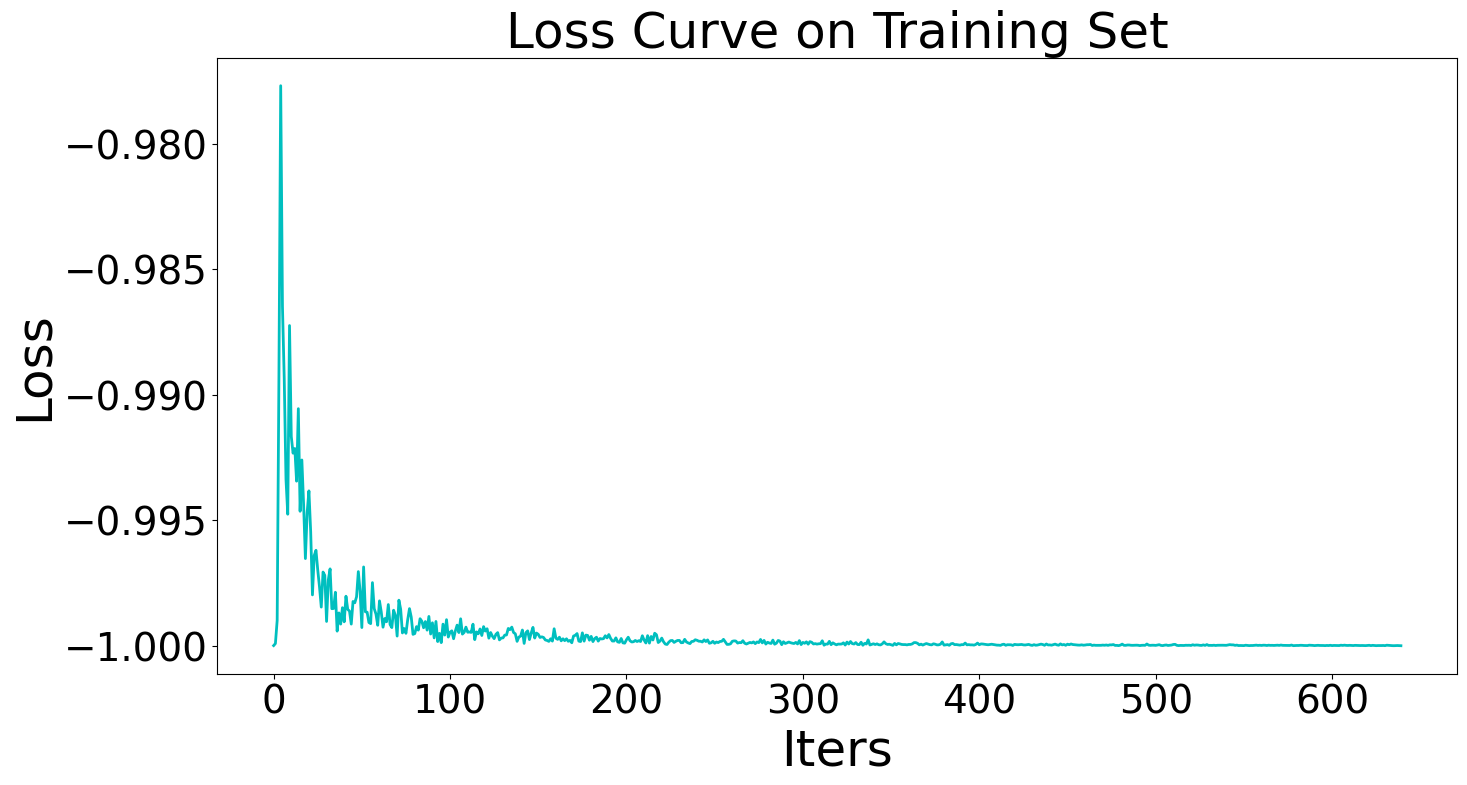

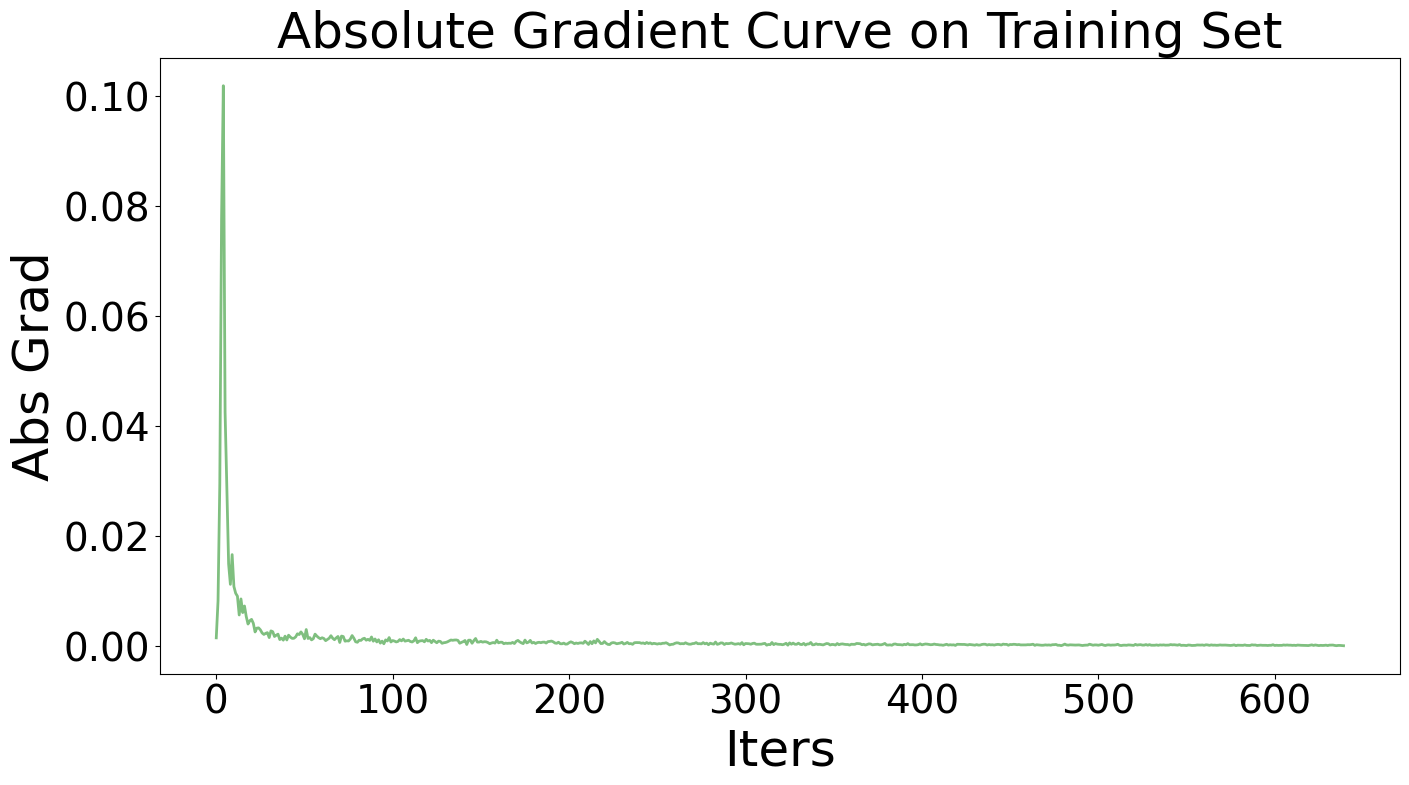

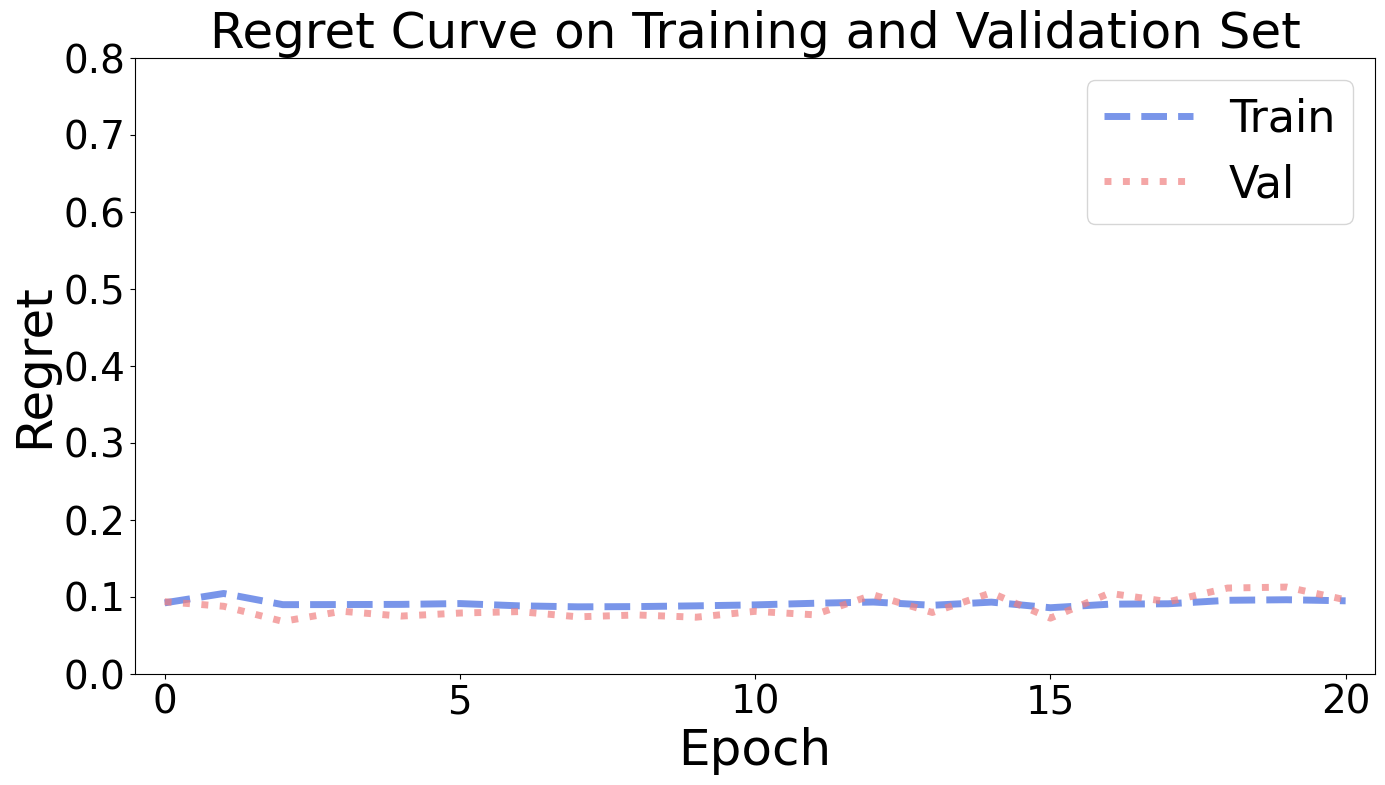

In [26]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)